In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
import time
import psutil
import ray
import os
import marshal
import scipy.interpolate
import types

from sklearn.linear_model import (LinearRegression, TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import curve_fit
    
from numpy.polynomial import *



In [2]:
# Params
r  = 1.025371/100 
dt = 0.5/365
T  = 180/365


LTV = 0.9
S0  = 58599.11
K   = S0 * LTV
PDL = 0.95 * S0

In [3]:
priceResults = pd.read_csv('priceResults_YouHodler.csv', index_col=0)

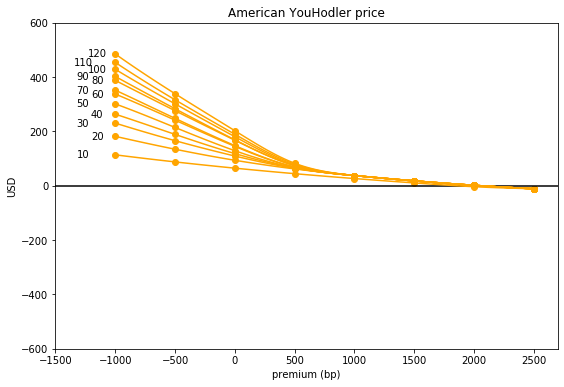

In [45]:
fill_value = 'extrapolate'

plt.figure(figsize=(9,6))
for i, endStep in enumerate([10*i for i in range(1,13)]):
    _id = priceResults.endStep == endStep

    _df = priceResults.loc[_id,:].copy()
    f = scipy.interpolate.interp1d(_df.bp, _df.AMprice, kind='cubic', fill_value=fill_value)
    bp_arr_test = np.linspace(-1000,2500,100)
    plt.scatter(_df.bp, _df.AMprice, color='orange')
    plt.plot(bp_arr_test, f(bp_arr_test), color='orange', label = 'AM price')

    plt.text(x=-1150-120*(i%2==0), y=_df.AMprice.iloc[0], s=endStep, va='center', ha='center')
    plt.xlim((-1500,2700))
    plt.ylim((-600,600))
plt.hlines(0, xmin=-1500, xmax=2700)

plt.xlabel('premium (bp)')
plt.ylabel('USD')
plt.title('American YouHodler price')
plt.savefig('americanYouHolderPrice.png', transparent=True)

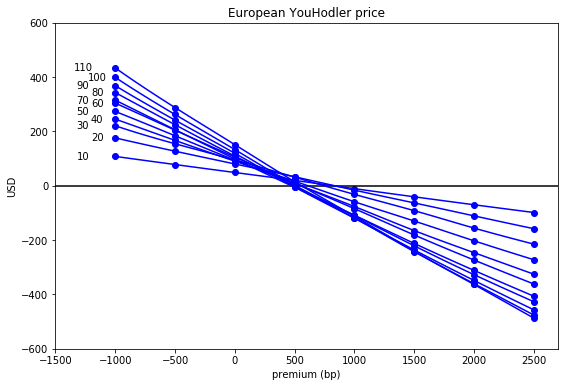

In [44]:
plt.figure(figsize=(9,6))
for i, endStep in enumerate([10*i for i in range(1,12)]):
    _id = priceResults.endStep == endStep

    _df = priceResults.loc[_id,:].copy()
    f = scipy.interpolate.interp1d(_df.bp, _df.EUprice, kind='cubic', fill_value=fill_value)
    fill_value = 'extrapolate'
    bp_arr_test = np.linspace(-1000,2500,100)
    plt.scatter(_df.bp, _df.EUprice, color='blue')
    plt.plot(bp_arr_test, f(bp_arr_test), color='blue', label = 'EU price')

    plt.text(x=-1150-120*(i%2==0), y=_df.EUprice.iloc[0], s=endStep, va='center', ha='center')
    plt.xlim((-1500,2700))
    plt.ylim((-600,600))
    
plt.hlines(0, xmin=-1500, xmax=2700)

plt.title('European YouHodler price')
plt.xlabel('premium (bp)')
plt.ylabel('USD')
plt.savefig('europeanYouHolderPrice.png', transparent=True)


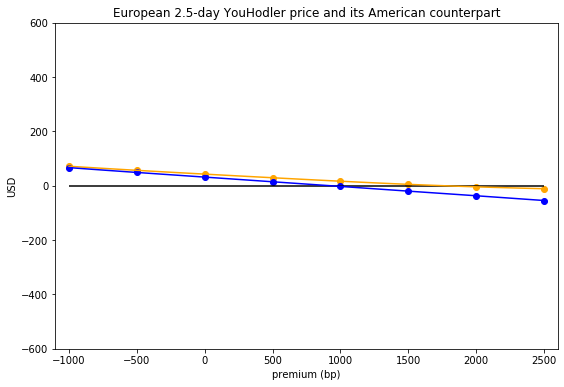

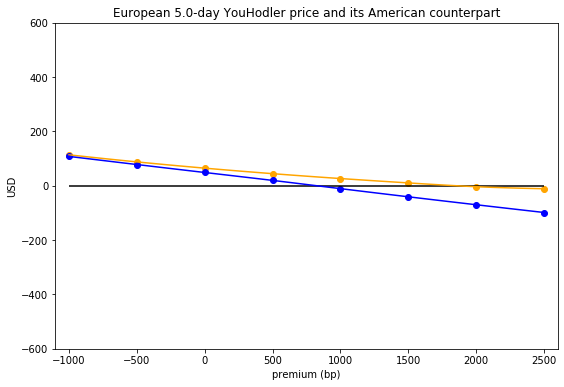

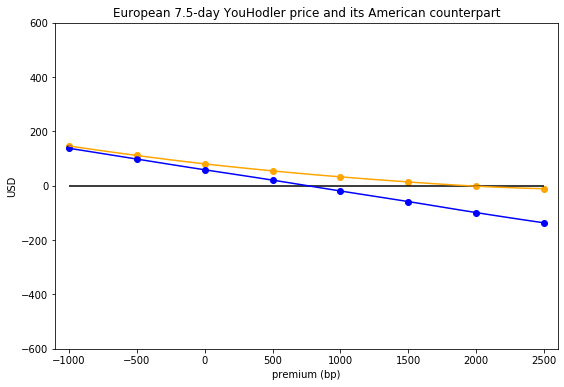

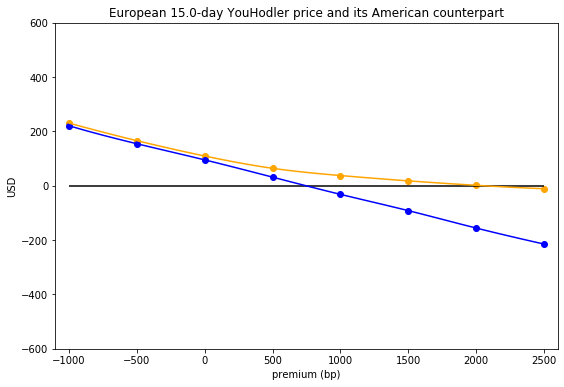

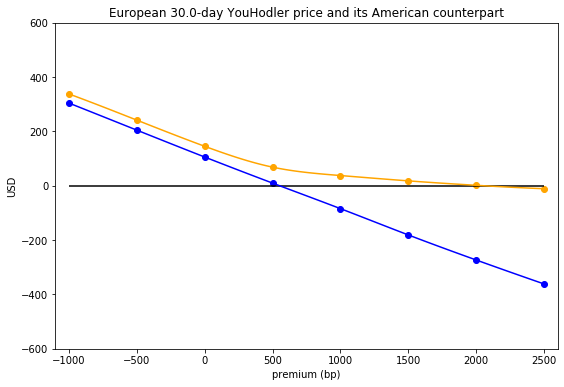

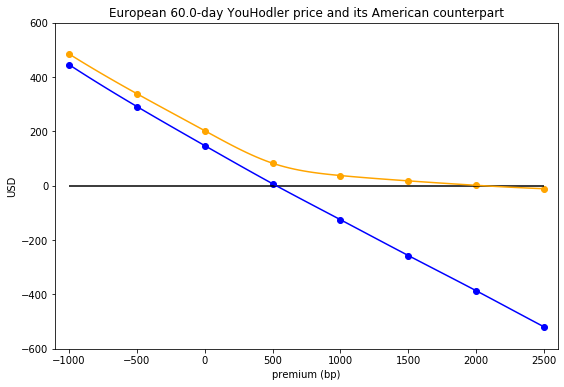

In [23]:
for endStep in [5, 10, 15, 30, 60, 120]:
    plt.figure(figsize=(9,6))

    _id = priceResults.endStep == endStep

    _df = priceResults.loc[_id,:].copy()
    f = scipy.interpolate.interp1d(_df.bp, _df.AMprice, kind='cubic', fill_value=fill_value)
    fill_value = 'extrapolate'
    bp_arr_test = np.linspace(-1000,2500,100)
    plt.scatter(_df.bp, _df.AMprice, color='orange')
    plt.plot(bp_arr_test, f(bp_arr_test), color='orange', label = 'AM price')


    f = scipy.interpolate.interp1d(_df.bp, _df.EUprice, kind='cubic', fill_value=fill_value)
    fill_value = 'extrapolate'
    plt.scatter(_df.bp, _df.EUprice, color='blue')
    plt.plot(bp_arr_test, f(bp_arr_test), color='blue', label = 'EU price')


    plt.title('European %.1f-day YouHodler price and its American counterpart'%(endStep/2))
    plt.hlines(0, xmin=-1000, xmax=2500)
    plt.xlabel('premium (bp)')
    plt.ylabel('USD')
    # plt.legend()


    f = scipy.interpolate.interp1d(_df.AMprice, _df.bp, kind='cubic', fill_value=fill_value)
    AMfairRate = f(0)

    f = scipy.interpolate.interp1d(_df.EUprice, _df.bp, kind='cubic', fill_value=fill_value)
    EUfairRate = f(0)

    plt.xlim((-1100,2600))
    plt.ylim((-600,600))
    plt.savefig('%.1fdayPlot.png'%(endStep/2), transparent=True)

In [24]:
endStep_arr = [i for i in range(1, 121)]

norm_q1 = scipy.stats.norm.ppf(.95)
# norm_q3 = scipy.stats.norm.ppf(.85)

AM_calibration_results = dict()
EU_calibration_results = dict()

# fill_value = - 99999

for endStep in endStep_arr:
    _id = priceResults.endStep == endStep
    bp_arr = priceResults.loc[_id,'bp']
    AMprice = priceResults.loc[_id,'AMprice']
    EUprice = priceResults.loc[_id,'EUprice']

    AM_sigma_hat = (priceResults.loc[_id,'AMprice_std'] + S0 - K)
    EU_sigma_hat = (priceResults.loc[_id,'EUprice_std'] + S0 - K)

    AM_q1 = AMprice-AM_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 
    AM_q3 = AMprice+AM_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 

    EU_q1 = EUprice-EU_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 
    EU_q3 = EUprice+EU_sigma_hat*norm_q1/np.sqrt(priceResults.loc[_id,'nPaths']) 
    
    AM_f    = scipy.interpolate.interp1d(AMprice, bp_arr, kind='cubic', fill_value=fill_value)
    AM_q1_f = scipy.interpolate.interp1d(AM_q1, bp_arr, kind='cubic', fill_value=fill_value)
    AM_q3_f = scipy.interpolate.interp1d(AM_q3, bp_arr, kind='cubic', fill_value=fill_value)

    AM_calibration_results[endStep*.5] = [AM_f(0), AM_q1_f(0), AM_q3_f(0)]
    
    EU_f    = scipy.interpolate.interp1d(EUprice, bp_arr, kind='cubic', fill_value=fill_value)
    EU_q1_f = scipy.interpolate.interp1d(EU_q1, bp_arr, kind='cubic', fill_value=fill_value)
    EU_q3_f = scipy.interpolate.interp1d(EU_q3, bp_arr, kind='cubic', fill_value=fill_value)

    EU_calibration_results[endStep*.5] = [EU_f(0), EU_q1_f(0), EU_q3_f(0)]
    
AM_calibration_results = pd.DataFrame(AM_calibration_results).T/10000
AM_calibration_results.columns = ['calibrated_r', 'calibrated_upper_r', 'calibrated_lower_r']

EU_calibration_results = pd.DataFrame(EU_calibration_results).T/10000
EU_calibration_results.columns = ['calibrated_r', 'calibrated_upper_r', 'calibrated_lower_r']


# plt.plot(pd.Series(calibration_results)/10000)
# plt.scatter(calibration_results.keys(),
#             pd.Series(calibration_results)/10000)

In [25]:
AM_calibration_results = AM_calibration_results.astype('float')
EU_calibration_results = EU_calibration_results.astype('float')

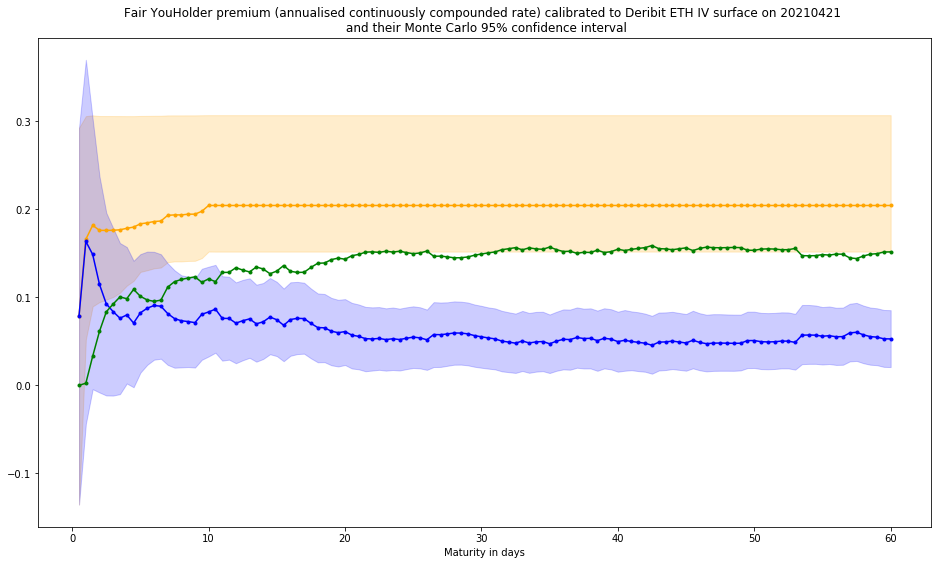

In [26]:
plt.figure(figsize=(16,9))

plt.plot(AM_calibration_results.calibrated_r, '.-', color='orange', label='AM')
# plt.scatter(AM_calibration_results.index, AM_calibration_results.calibrated_r, color=)


plt.fill_between(AM_calibration_results.index,
                 AM_calibration_results.calibrated_upper_r,
                 AM_calibration_results.calibrated_lower_r, alpha=0.2, color='orange')

plt.plot(EU_calibration_results.calibrated_r, '.-', color='blue', label='EU')
plt.fill_between(EU_calibration_results.index,
                 EU_calibration_results.calibrated_upper_r,
                 EU_calibration_results.calibrated_lower_r, alpha=0.2, color='blue')

spread = AM_calibration_results.calibrated_r - EU_calibration_results.calibrated_r
plt.plot(spread, 'g.-', label='AM-EU')

# plt.legend()
plt.xlabel('Maturity in days')
plt.title('Fair YouHolder premium (annualised continuously compounded rate) calibrated to Deribit ETH IV surface on 20210421 \n and their Monte Carlo 95% confidence interval')

# plt.xlim((0,120))
# plt.ylim((-0.075,.21))
plt.savefig('premiumCurve.png', transparent=True)

# plt.xlim((0,5))
# plt.plot(EU_calibration_results.calibrated_r)
# plt.plot(AM_calibration_results.calibrated_r-EU_calibration_results.calibrated_r)

In [47]:
EU_calibration_results.calibrated_r

0.5     0.078751
1.0     0.163443
1.5     0.148617
2.0     0.114593
2.5     0.092433
          ...   
58.0    0.057357
58.5    0.055345
59.0    0.054714
59.5    0.052837
60.0    0.052696
Name: calibrated_r, Length: 120, dtype: float64